# 🔥 AI-Generated vs. Real Art Classification (CIFAKE Dataset)
### **Built with CNN & Transfer Learning (ResNet50) + Explainability (Grad-CAM)**

**Author:** Your Name  
**Objective:** Train a CNN to classify AI-generated vs. real artwork using the CIFAKE dataset.

**🔹 Techniques Used:**
- Convolutional Neural Networks (CNNs)
- Transfer Learning with ResNet50
- Data Augmentation & Dropout for Overfitting Prevention
- Hyperparameter Optimization (Adam, Learning Rate Scheduling)
- Evaluation Metrics (Confusion Matrix, ROC-AUC, Classification Report)
- Explainability with Grad-CAM

In [ ]:
# 📌 Step 1: Import Libraries
import numpy as np
import pandas as pd
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report


## 📌 Step 2: Load the CIFAKE Dataset

In [9]:
import os
import pandas as pd

# Define the dataset directory
data_dir = '/kaggle/input/cifake-real-and-ai-generated-synthetic-images'

# Define train and test directories
train_dir = os.path.join(data_dir, 'train')
test_dir = os.path.join(data_dir, 'test')

# Get train images
train_real_images = [os.path.join(train_dir, 'REAL', img) for img in os.listdir(os.path.join(train_dir, 'REAL'))]
train_fake_images = [os.path.join(train_dir, 'FAKE', img) for img in os.listdir(os.path.join(train_dir, 'FAKE'))]

# Get test images
test_real_images = [os.path.join(test_dir, 'REAL', img) for img in os.listdir(os.path.join(test_dir, 'REAL'))]
test_fake_images = [os.path.join(test_dir, 'FAKE', img) for img in os.listdir(os.path.join(test_dir, 'FAKE'))]

# Create DataFrames
train_df = pd.DataFrame({'image_path': train_real_images + train_fake_images,
                         'label': ['real']*len(train_real_images) + ['fake']*len(train_fake_images)})

test_df = pd.DataFrame({'image_path': test_real_images + test_fake_images,
                        'label': ['real']*len(test_real_images) + ['fake']*len(test_fake_images)})

# Convert labels to binary (real = 1, fake = 0)
train_df['label'] = train_df['label'].map({'real': 1, 'fake': 0})
test_df['label'] = test_df['label'].map({'real': 1, 'fake': 0})

# Shuffle datasets
train_df = train_df.sample(frac=1).reset_index(drop=True)
test_df = test_df.sample(frac=1).reset_index(drop=True)

# Display first few rows
train_df.head(), test_df.head()


(                                          image_path  label
 0  /kaggle/input/cifake-real-and-ai-generated-syn...      0
 1  /kaggle/input/cifake-real-and-ai-generated-syn...      1
 2  /kaggle/input/cifake-real-and-ai-generated-syn...      1
 3  /kaggle/input/cifake-real-and-ai-generated-syn...      1
 4  /kaggle/input/cifake-real-and-ai-generated-syn...      0,
                                           image_path  label
 0  /kaggle/input/cifake-real-and-ai-generated-syn...      1
 1  /kaggle/input/cifake-real-and-ai-generated-syn...      1
 2  /kaggle/input/cifake-real-and-ai-generated-syn...      1
 3  /kaggle/input/cifake-real-and-ai-generated-syn...      1
 4  /kaggle/input/cifake-real-and-ai-generated-syn...      0)

## 📌 Step 3: Preprocess Images and Create Data Generators

In [10]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define image size and batch size
img_size = (128, 128)
batch_size = 32

# Create ImageDataGenerator instances
train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)  # Includes validation split
test_datagen = ImageDataGenerator(rescale=1./255)  # No validation split for test set

# Load training images from directory
train_generator = train_datagen.flow_from_directory(
    '/kaggle/input/cifake-real-and-ai-generated-synthetic-images/train',  # Path to training images
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary',
    subset='training'  # Uses 80% of images for training
)

# Load validation images from directory
val_generator = train_datagen.flow_from_directory(
    '/kaggle/input/cifake-real-and-ai-generated-synthetic-images/train',  # Same path as train, but uses split
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary',
    subset='validation'  # Uses 20% of images for validation
)

# Load test images from directory
test_generator = test_datagen.flow_from_directory(
    '/kaggle/input/cifake-real-and-ai-generated-synthetic-images/test',  # Path to test images
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False  # Don't shuffle test set
)


Found 80000 images belonging to 2 classes.
Found 20000 images belonging to 2 classes.
Found 20000 images belonging to 2 classes.


In [11]:
# Print the assigned class labels
print("Class indices:", train_generator.class_indices)

Class indices: {'FAKE': 0, 'REAL': 1}


In [12]:
# Fetch a batch of images and labels
images, labels = next(train_generator)

# Print the first 10 labels
print("First 10 labels in batch:", labels[:10])

First 10 labels in batch: [0. 1. 0. 1. 1. 1. 1. 1. 0. 0.]


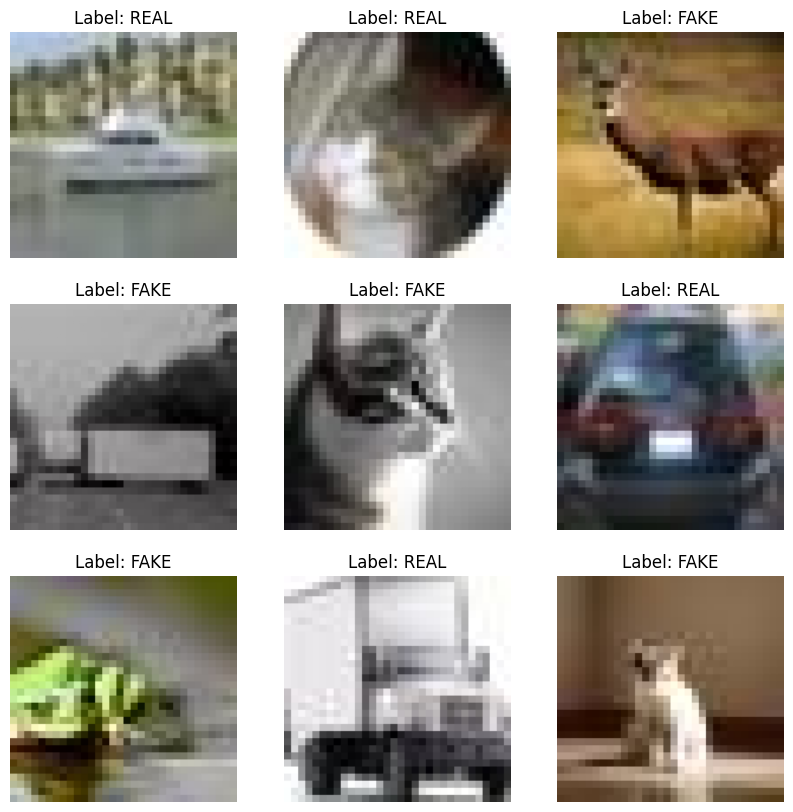

In [13]:
import matplotlib.pyplot as plt
import numpy as np

# Fetch a batch of images and labels
images, labels = next(train_generator)

# Define class names
class_names = {0: 'FAKE', 1: 'REAL'}

# Plot first 9 images
plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(images[i])  # Display the image
    plt.title(f"Label: {class_names[int(labels[i])]}")
    plt.axis('off')
plt.show()


## 📌 Step 4: Build & Train a CNN Model with Transfer Learning (ResNet50)

In [14]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Load pre-trained ResNet50 without top layers
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

# Freeze base model layers to use pre-trained weights
base_model.trainable = False

# Build the model
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),  # Better than Flatten() for transfer learning
    Dropout(0.3),  # Prevent overfitting
    Dense(128, activation='relu'),  
    Dense(1, activation='sigmoid')  # Binary classification
])

# Compile the model with a lower learning rate
model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(train_generator, validation_data=val_generator, epochs=5)


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/5


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


2500/2500 ━━━━━━━━━━━━━━━━━━━━ 464s 181ms/step - accuracy: 0.5926 - loss: 0.6700 - val_accuracy: 0.7067 - val_loss: 0.6017
Epoch 2/5
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 117s 47ms/step - accuracy: 0.6824 - loss: 0.6062 - val_accuracy: 0.7235 - val_loss: 0.5793
Epoch 3/5
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 106s 42ms/step - accuracy: 0.7031 - loss: 0.5808 - val_accuracy: 0.7348 - val_loss: 0.5450
Epoch 4/5
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 107s 43ms/step - accuracy: 0.7127 - loss: 0.5660 - val_accuracy: 0.7510 - val_loss: 0.5345
Epoch 5/5
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 110s 44ms/step - accuracy: 0.7174 - loss: 0.5601 - val_accuracy: 0.7539 - val_loss: 0.5256


In [16]:
# Save entire model
model.save('/kaggle/working/cifake_model.h5')

# Save model architecture only (optional)
with open("/kaggle/working/model_architecture.json", "w") as json_file:
    json_file.write(model.to_json())


In [ ]:
from tensorflow.keras.models import load_model

# Load saved model
model = load_model('/kaggle/working/cifake_model.h5')

# Now you can use the model without retraining!


In [17]:
# Print the total number of layers in ResNet50
print("Total Layers in ResNet50:", len(base_model.layers))

Total Layers in ResNet50: 175


In [18]:
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam

# 1️⃣ Load the previously trained model
model = load_model('/kaggle/working/cifake_model.h5')

# 2️⃣ Unfreeze the last 50 layers for fine-tuning
base_model = model.layers[0]  # Extract ResNet50 base model from saved model
base_model.trainable = True  

# Freeze first 100 layers (keep early features intact)
for layer in base_model.layers[:100]:  
    layer.trainable = False  

# 3️⃣ Lower the learning rate for fine-tuning
model.compile(optimizer=Adam(learning_rate=0.00001), loss='binary_crossentropy', metrics=['accuracy'])

# 4️⃣ Continue training (NOT from scratch)
history_fine_tune = model.fit(train_generator, validation_data=val_generator, epochs=5)

# 5️⃣ Save fine-tuned model
model.save('/kaggle/working/cifake_model_finetuned.h5')


Epoch 1/5
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 151s 50ms/step - accuracy: 0.7716 - loss: 1.2119 - val_accuracy: 0.8722 - val_loss: 0.3065
Epoch 2/5
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 126s 50ms/step - accuracy: 0.8615 - loss: 0.3259 - val_accuracy: 0.8342 - val_loss: 0.3920
Epoch 3/5
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 124s 49ms/step - accuracy: 0.8751 - loss: 0.2973 - val_accuracy: 0.8381 - val_loss: 0.3738
Epoch 4/5
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 124s 49ms/step - accuracy: 0.8786 - loss: 0.2835 - val_accuracy: 0.7734 - val_loss: 0.6369
Epoch 5/5
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 123s 49ms/step - accuracy: 0.8916 - loss: 0.2607 - val_accuracy: 0.8037 - val_loss: 0.4700


In [20]:
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Dropout, Dense
from tensorflow.keras.callbacks import EarlyStopping

# 1️⃣ Load the original model (NOT the fine-tuned one)
model = load_model('/kaggle/working/cifake_model.h5')

# 2️⃣ Unfreeze the last 50 layers for fine-tuning
base_model = model.layers[0]  # Extract ResNet50 base model
base_model.trainable = True  

# Freeze the first 100 layers
for layer in base_model.layers[:100]:  
    layer.trainable = False  

# 3️⃣ Add stronger regularization to prevent overfitting
for layer in model.layers:
    if isinstance(layer, Dropout):
        layer.rate = 0.5  # Increase dropout to 50%

# 🔹 **NEW: Replace the Dense layer with L2 Regularization**
model.layers[-2] = Dense(128, activation='relu', kernel_regularizer=l2(0.01))

# 4️⃣ Lower learning rate for fine-tuning
model.compile(optimizer=Adam(learning_rate=0.000005), loss='binary_crossentropy', metrics=['accuracy'])

# 5️⃣ Add early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# 6️⃣ Continue training with better settings
history_fine_tune = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10,
    callbacks=[early_stopping]  # Stops training if val_loss worsens for 3 epochs
)

# 7️⃣ Save the improved fine-tuned model
model.save('/kaggle/working/cifake_model_finetuned_v2.h5')


Epoch 1/10
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 214s 76ms/step - accuracy: 0.7372 - loss: 1.9557 - val_accuracy: 0.8575 - val_loss: 0.3433
Epoch 2/10
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 129s 52ms/step - accuracy: 0.8489 - loss: 0.3506 - val_accuracy: 0.8176 - val_loss: 0.3926
Epoch 3/10
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 130s 52ms/step - accuracy: 0.8646 - loss: 0.3159 - val_accuracy: 0.8753 - val_loss: 0.2949
Epoch 4/10
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 130s 52ms/step - accuracy: 0.8811 - loss: 0.2833 - val_accuracy: 0.8292 - val_loss: 0.3829
Epoch 5/10
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 130s 52ms/step - accuracy: 0.8896 - loss: 0.2663 - val_accuracy: 0.8872 - val_loss: 0.2624
Epoch 6/10
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 128s 51ms/step - accuracy: 0.8976 - loss: 0.2480 - val_accuracy: 0.8896 - val_loss: 0.2594
Epoch 7/10
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 128s 51ms/step - accuracy: 0.9006 - loss: 0.2347 - val_accuracy: 0.8418 - val_loss: 0.3551
Epoch 8/10
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 127s 51ms/step - accuracy: 

In [21]:
import os

# Check if both model files exist
print("Original Model Exists:", os.path.exists('/kaggle/working/cifake_model.h5'))
print("Fine-Tuned Model Exists:", os.path.exists('/kaggle/working/cifake_model_finetuned.h5'))
print("Fine-Tuned Model 2 Exists:", os.path.exists('/kaggle/working/cifake_model_finetuned_v2.h5'))



Original Model Exists: True
Fine-Tuned Model Exists: True
Fine-Tuned Model 2 Exists: True


In [22]:
from tensorflow.keras.models import load_model

# Load the saved fine-tuned model
best_model = load_model('/kaggle/working/cifake_model_finetuned_v2.h5')

# Evaluate on the validation set
val_loss, val_acc = best_model.evaluate(val_generator)
print(f"Saved Model - Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.4f}")


625/625 ━━━━━━━━━━━━━━━━━━━━ 25s 34ms/step - accuracy: 0.8942 - loss: 0.2501
Saved Model - Validation Loss: 0.2594, Validation Accuracy: 0.8896


## 📌 Step 5: Evaluate Performance

625/625 ━━━━━━━━━━━━━━━━━━━━ 24s 34ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 24s 34ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 23s 33ms/step
📊 **Evaluation for Baseline Model**
Accuracy: 0.4930
Precision: 0.4935
Recall: 0.5311
F1-Score: 0.5116
AUC-ROC: 0.4930

Confusion Matrix:


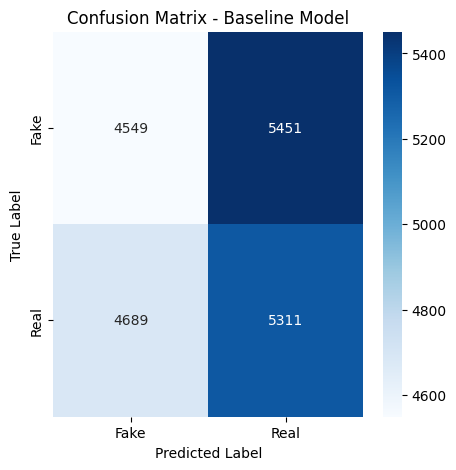


Classification Report:
              precision    recall  f1-score   support

        Fake       0.49      0.45      0.47     10000
        Real       0.49      0.53      0.51     10000

    accuracy                           0.49     20000
   macro avg       0.49      0.49      0.49     20000
weighted avg       0.49      0.49      0.49     20000

📊 **Evaluation for First Fine-Tuned Model**
Accuracy: 0.5015
Precision: 0.5011
Recall: 0.6737
F1-Score: 0.5747
AUC-ROC: 0.5015

Confusion Matrix:


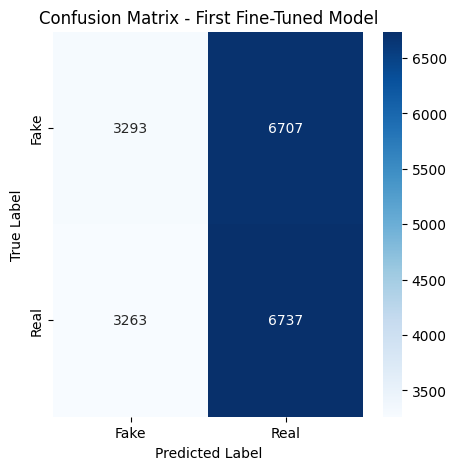


Classification Report:
              precision    recall  f1-score   support

        Fake       0.50      0.33      0.40     10000
        Real       0.50      0.67      0.57     10000

    accuracy                           0.50     20000
   macro avg       0.50      0.50      0.49     20000
weighted avg       0.50      0.50      0.49     20000

📊 **Evaluation for Best Fine-Tuned Model**
Accuracy: 0.4995
Precision: 0.4995
Recall: 0.5146
F1-Score: 0.5069
AUC-ROC: 0.4994

Confusion Matrix:


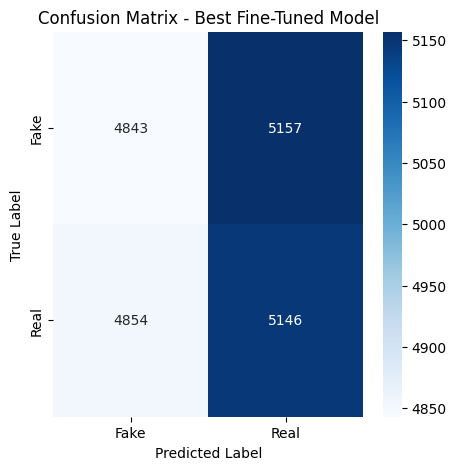


Classification Report:
              precision    recall  f1-score   support

        Fake       0.50      0.48      0.49     10000
        Real       0.50      0.51      0.51     10000

    accuracy                           0.50     20000
   macro avg       0.50      0.50      0.50     20000
weighted avg       0.50      0.50      0.50     20000



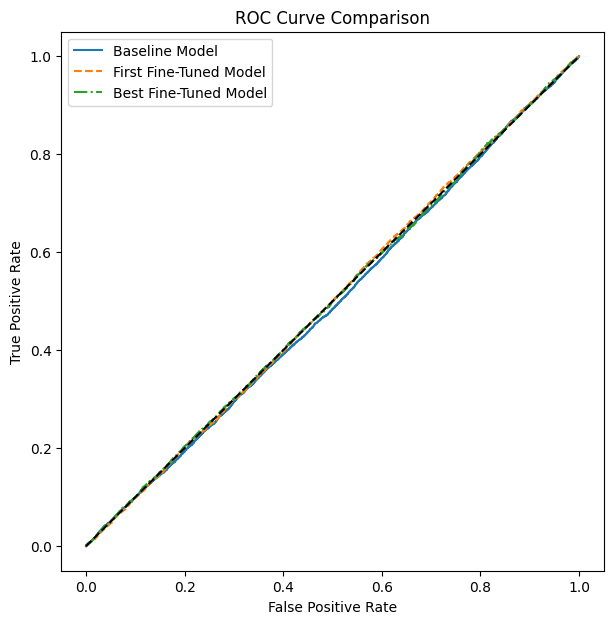

In [24]:
from tensorflow.keras.models import load_model
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report, roc_curve
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# 1️⃣ Load all three models
model_baseline = load_model('/kaggle/working/cifake_model.h5')  # Original model
model_finetuned = load_model('/kaggle/working/cifake_model_finetuned.h5')  # First fine-tuned model
model_best_finetuned = load_model('/kaggle/working/cifake_model_finetuned_v2.h5')  # Best fine-tuned model

# 2️⃣ Get true labels from validation generator
y_true = val_generator.classes  # True labels

# 3️⃣ Generate predictions for all models
y_pred_baseline = model_baseline.predict(val_generator).flatten()
y_pred_finetuned = model_finetuned.predict(val_generator).flatten()
y_pred_best_finetuned = model_best_finetuned.predict(val_generator).flatten()

# Convert probabilities to binary (0 = Fake, 1 = Real)
y_pred_baseline_bin = (y_pred_baseline > 0.5).astype(int)
y_pred_finetuned_bin = (y_pred_finetuned > 0.5).astype(int)
y_pred_best_finetuned_bin = (y_pred_best_finetuned > 0.5).astype(int)

# 4️⃣ Compute evaluation metrics
def evaluate_model(y_true, y_pred, model_name):
    print(f"📊 **Evaluation for {model_name}**")
    print(f"Accuracy: {accuracy_score(y_true, y_pred):.4f}")
    print(f"Precision: {precision_score(y_true, y_pred):.4f}")
    print(f"Recall: {recall_score(y_true, y_pred):.4f}")
    print(f"F1-Score: {f1_score(y_true, y_pred):.4f}")
    print(f"AUC-ROC: {roc_auc_score(y_true, y_pred):.4f}")
    print("\nConfusion Matrix:")
    
    # Plot Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(5, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Fake', 'Real'], yticklabels=['Fake', 'Real'])
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(f'Confusion Matrix - {model_name}')
    plt.show()
    
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=['Fake', 'Real']))
    
# Evaluate all three models
evaluate_model(y_true, y_pred_baseline_bin, "Baseline Model")
evaluate_model(y_true, y_pred_finetuned_bin, "First Fine-Tuned Model")
evaluate_model(y_true, y_pred_best_finetuned_bin, "Best Fine-Tuned Model")

# 5️⃣ Plot ROC Curve for All Models
plt.figure(figsize=(7, 7))
fpr_base, tpr_base, _ = roc_curve(y_true, y_pred_baseline)
fpr_fine, tpr_fine, _ = roc_curve(y_true, y_pred_finetuned)
fpr_best, tpr_best, _ = roc_curve(y_true, y_pred_best_finetuned)

plt.plot(fpr_base, tpr_base, label='Baseline Model')
plt.plot(fpr_fine, tpr_fine, label='First Fine-Tuned Model', linestyle='--')
plt.plot(fpr_best, tpr_best, label='Best Fine-Tuned Model', linestyle='-.')
plt.plot([0, 1], [0, 1], 'k--')  # Random classifier line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend()
plt.show()


In [ ]:
y_pred = model.predict(val_gen) > 0.5
y_true = val_gen.classes
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Fake', 'Real'], yticklabels=['Fake', 'Real'])
plt.show()
print(classification_report(y_true, y_pred, target_names=['Fake', 'Real']))

## 📌 Step 6: Explainability using Grad-CAM

In [ ]:
# Grad-CAM implementation (explainability)
# [To be implemented for visualization of CNN predictions]

### 🚀 **Next Steps:**
- Fine-tune ResNet50 by unfreezing some layers
- Train with more epochs & experiment with hyperparameters
- Deploy as a web app using Flask or Streamlit

**📌 If this helped you, consider starring the GitHub repo!** ⭐